In [23]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
from torch.utils.data import DataLoader
from diffusion_model import DenoisingMLP
from diffusion_utils import DiffusionProcess, linear_schedule, quadratic_schedule, cosine_schedule
from diffusion_evalmetrics import mmd, ot_sinkhorn
from celldataset import SingleCellDataset
import scanpy as sc
from torch.optim import Adam
from umap import UMAP
import matplotlib.pyplot as plt
from tqdm import tqdm

/opt/conda/jwenckst/envs/scset/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
adata = sc.read_h5ad("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds_SAMPLEPOOL_for_covidPFnormal_n213.h5ad")

In [25]:
dataset = SingleCellDataset(adata, adata_layer='X_scanvi_emb', split='all')
dl = DataLoader(dataset, batch_size=64, shuffle=True)
sample_size = dataset[0].shape[0]

In [26]:
num_timesteps = 1000

epochs = 5

beta_start = 0.0001
beta_end = 0.02
betas = linear_schedule(beta_start, beta_end, num_timesteps)
betas = cosine_schedule(num_timesteps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dp = DiffusionProcess(betas=betas)
dp.to(device)

DiffusionProcess()

In [27]:
denoise_model = DenoisingMLP(sample_dim=dataset[0].shape[-1], time_emb_dim=128, condition_dim=128, num_res_blocks=5, activation='silu')
denoise_model.to(device=device)

optimizer = Adam(denoise_model.parameters(), lr=1e-3)

In [28]:
avg_loss = 0
max_norm = 0    

for iteration, batch in enumerate(dl):        
    optimizer.zero_grad()

    batch = batch.to(device=device)
    tidx = torch.randint(0, num_timesteps, (batch.shape[0],), dtype=torch.long).to(device=device)

    loss = dp.p_loss(denoise_model, batch, tidx, loss_fn='l2')
    loss.backward()

    for p in denoise_model.parameters():
        if p.grad is not None:
            norm = p.grad.norm(2)
            max_norm = max(max_norm, norm)

    optimizer.step()

    avg_loss += loss.item()

    if iteration % 1000 == 0:
        print(f'Iteration {iteration}: {avg_loss/1000}. Max grad norm: {max_norm}')
        avg_loss = 0
        max_norm = 0

Iteration 0: 0.000580016016960144. Max grad norm: 0.015197900123894215
Iteration 1000: 0.37124225121736526. Max grad norm: 0.12397990375757217
Iteration 2000: 0.34137444937229156. Max grad norm: 0.0915001854300499
Iteration 3000: 0.3333817259669304. Max grad norm: 0.10565280169248581
Iteration 4000: 0.33170354408025743. Max grad norm: 0.10178981721401215
Iteration 5000: 0.32757872171700003. Max grad norm: 0.09518255293369293
Iteration 6000: 0.32646101839840413. Max grad norm: 0.10463482141494751
Iteration 7000: 0.3249729754626751. Max grad norm: 0.12235389649868011
Iteration 8000: 0.32462572722136973. Max grad norm: 0.12681721150875092
Iteration 9000: 0.3208107147216797. Max grad norm: 0.09323036670684814
Iteration 10000: 0.32153516276180744. Max grad norm: 0.11599104106426239
Iteration 11000: 0.3212107881009579. Max grad norm: 0.09366903454065323


In [22]:
ax = torch.randn(1000, 1000, 5000).to(device)

In [23]:
num_samples = 2000
samples = dp.p_sample(denoise_model, (num_samples, dataset[0].shape[-1])).cpu()

In [25]:
umap_reducer = UMAP(n_components=2)

true_cells = dataset.cells[torch.randint(0, len(dataset), (num_samples,))]

#all_cells = torch.cat([true_cells, samples], dim=0)

umap_reducer.fit(true_cells)

umap_true_cells = umap_reducer.transform(true_cells.cpu().numpy())
umap_samples = umap_reducer.transform(samples.detach().cpu().numpy())

mean = true_cells.mean(dim=0)
std = true_cells.std(dim=0)

bad_samples = torch.randn_like(samples) * std + mean
umap_bad_samples = umap_reducer.transform(bad_samples.detach().cpu().numpy())

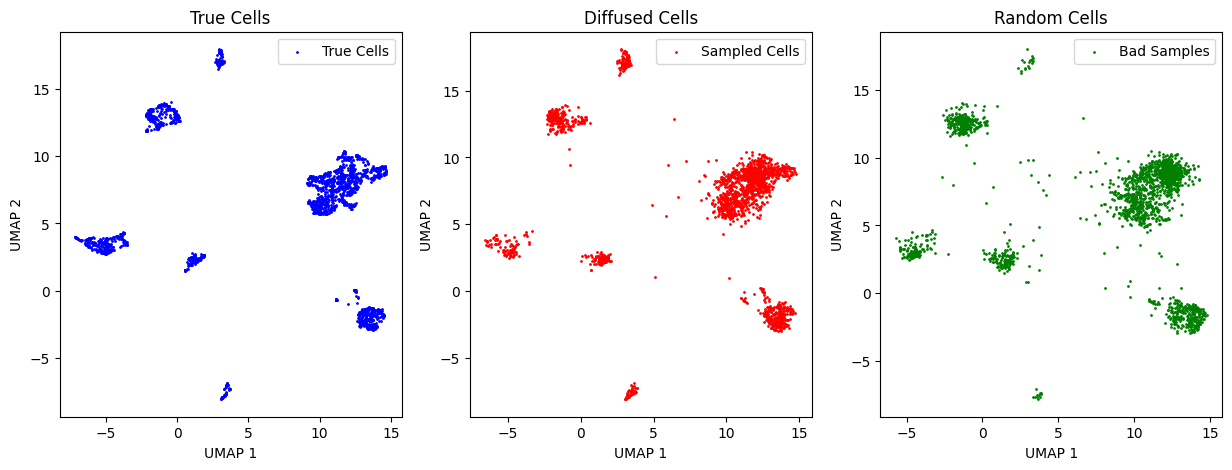

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(umap_true_cells[:, 0], umap_true_cells[:, 1], color='blue', label='True Cells', s=1)
ax[0].set_title('True Cells')
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
ax[0].legend()

ax[1].scatter(umap_samples[:, 0], umap_samples[:, 1], color='red', label='Sampled Cells', s=1)
ax[1].set_title('Diffused Cells')
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
ax[1].legend()

ax[2].scatter(umap_bad_samples[:, 0], umap_bad_samples[:, 1], color='green', label='Bad Samples', s=1)
ax[2].set_title('Random Cells')
ax[2].set_xlabel('UMAP 1')
ax[2].set_ylabel('UMAP 2')
ax[2].legend()

plt.show()

In [27]:
from sklearn.decomposition import PCA

pca_reducer = PCA(n_components=2)

pca_reducer.fit(true_cells)

pca_true_cells = pca_reducer.transform(true_cells.cpu().numpy())
pca_samples = pca_reducer.transform(samples.detach().cpu().numpy())

mean = true_cells.mean(dim=0)
std = true_cells.std(dim=0)

bad_samples = torch.randn_like(samples) * std + mean
pca_bad_samples = pca_reducer.transform(bad_samples.detach().cpu().numpy())

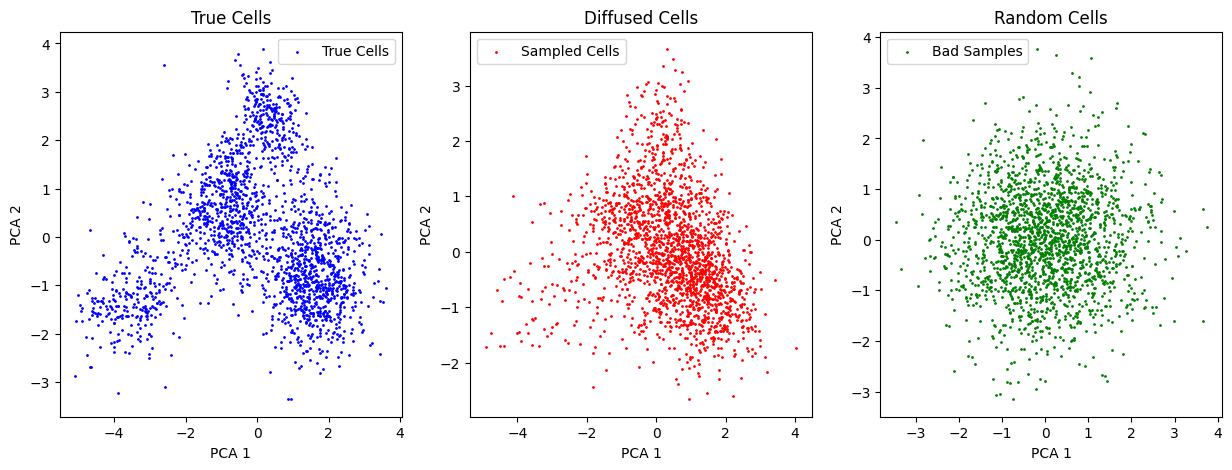

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(pca_true_cells[:, 0], pca_true_cells[:, 1], color='blue', label='True Cells', s=1)
ax[0].set_title('True Cells')
ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[0].legend()

ax[1].scatter(pca_samples[:, 0], pca_samples[:, 1], color='red', label='Sampled Cells', s=1)
ax[1].set_title('Diffused Cells')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[1].legend()

ax[2].scatter(pca_bad_samples[:, 0], pca_bad_samples[:, 1], color='green', label='Bad Samples', s=1)
ax[2].set_title('Random Cells')
ax[2].set_xlabel('PCA 1')
ax[2].set_ylabel('PCA 2')
ax[2].legend()

plt.show()

In [16]:
print(f'MMD (Linear): {mmd(true_cells, samples, kernel="linear")}')
print(f'MMD (Gaussian): {mmd(true_cells, samples, kernel="gaussian")}')
print(f'OT (Sinkhorn): {ot_sinkhorn(true_cells, samples, reg=0.01)}')

dist = mmd(true_cells, samples, kernel='gaussian')

MMD (Linear): 0.3330000936985016
MMD (Gaussian): 0.03666871041059494
OT (Sinkhorn): 3.30517840385437


In [17]:
print(f'MMD (Linear): {mmd(true_cells, bad_samples, kernel="linear")}')
print(f'MMD (Gaussian): {mmd(true_cells, bad_samples, kernel="gaussian")}')
print(f'OT (Sinkhorn): {ot_sinkhorn(true_cells, bad_samples, reg=0.01)}')


MMD (Linear): 0.09281778335571289
MMD (Gaussian): 0.04049137234687805
OT (Sinkhorn): 4.1425604820251465
